In [2]:
import pandas as pd
from rds_db_interact import Table_sqls
from Secrets import hostname,DB_password,DB_username,DB_name

table_interact = Table_sqls(hostname,DB_username,DB_username,DB_password)

# %%
class Data_cleaner:
    def __init__(self,table_interact):
        self = self
        self.table_interact = table_interact

    def drop_duplicates(self,df,on_columns,identifier):
        subset=  on_columns
        dups = df.duplicated(subset=subset)
        print(dups)
        # print(dups.describe(include = ["category"]))
    def describe_categories(self,table,column,descriptions):
        df = table.groupby(column)[descriptions].nunique()
        print(df)


# clean_data = Data_cleaner(table_interact)

# games = table_interact.get_table_as_pd("games")
# moves = table_interact.get_table_as_pd("moves")
countries = table_interact.get_table_as_pd("countries")
# players = table_interact.get_table_as_pd("players")



In [3]:
#getting relevant player data per game
sql = '''SELECT DISTINCT(player_white_username) from games'''
con = table_interact.connect()
players_white = pd.read_sql_query(sql,con)

sql = '''SELECT DISTINCT(player_black_username) from games'''
con = table_interact.connect()
players_black = pd.read_sql_query(sql,con)

sql = '''SELECT DISTINCT(username) from players'''
con = table_interact.connect()
saved_players = pd.read_sql_query(sql,con)

In [4]:
distinct_white = set(players_white['player_white_username'])
distinct_black = set(players_black['player_black_username'])
distinct_game_players = distinct_white|distinct_black
unsaved = set(distinct_game_players).difference(set(saved_players['username']))

In [5]:
# from ChessComData import get_player_data,get_fide

# columns_players = "player_id, username, name, join_date, country_code,       streamer_status, title,fide_elo"
# for name in set(unsaved):
#     pd = get_player_data(str(name))
# # values to be inputted in rds players sql table
#     fide = get_fide(name)
#     values_players = f"{pd['player_id']},'{name}','{pd['name']}',{pd['join_date']}," + \
#             f"'{pd['country_code']}','{pd['is_streamer']}','{pd['title']}',{fide} "
# # saving to rds table players
#     table_interact.insert_into_table(
#             'players', columns_players, values_players)

In [6]:
country_info = pd.read_excel("country_info.xlsx")
relavent_country = country_info[["country_code ","utc time"]]

In [7]:
pd.DataFrame(relavent_country.groupby("country_code ").count()).sort_values(by="utc time",ascending=False)


,utc time
country_code,
US,29
CA,28
RU,26
BR,16
AU,12
...,...
HN,1
HR,1
HT,1


In [8]:
set(relavent_country["utc time"])



{'UTC',
 'UTC +01:00',
 'UTC +02:00',
 'UTC +03:00',
 'UTC +04:00',
 'UTC +04:30',
 'UTC +05:00',
 'UTC +05:30',
 'UTC +05:45',
 'UTC +06:00',
 'UTC +06:30',
 'UTC +07:00',
 'UTC +08:00',
 'UTC +08:45',
 'UTC +09:00',
 'UTC +09:30',
 'UTC +10:00',
 'UTC +10:30',
 'UTC +11:00',
 'UTC +12:00',
 'UTC +13:00',
 'UTC +13:45',
 'UTC +14:00',
 'UTC -01:00',
 'UTC -02:00',
 'UTC -02:30',
 'UTC -03:00',
 'UTC -04:00',
 'UTC -05:00',
 'UTC -06:00',
 'UTC -07:00',
 'UTC -08:00',
 'UTC -09:00',
 'UTC -09:30',
 'UTC -10:00',
 'UTC -11:00'}

In [9]:
relavent_country["utc time"] = relavent_country["utc time"].map(lambda time : time.replace("UTC ","") )

In [10]:
relavent_country["utc time"] = relavent_country["utc time"].map(lambda time : time.replace("UTC","+00:00") )

In [11]:
relavent_country["utc time"]

0      +04:30
1      +02:00
2      +01:00
3      -11:00
4      +02:00
        ...  
419    +01:00
420    +03:00
421    +02:00
422    +02:00
423    +03:00
Name: utc time, Length: 424, dtype: object

In [12]:
relavent_country["late_early"] = relavent_country["utc time"].map(lambda time: time[0])

In [13]:
relavent_country["utc time"] = relavent_country["utc time"].map(lambda time:time.strip(time[0]))

In [14]:
relavent_country.loc[relavent_country["country_code "]=="US"]

,country_code,utc time,late_early
379,US,09:00,-
380,US,08:00,-
381,US,06:00,-
382,US,05:00,-
383,US,06:00,-
384,US,04:00,-
385,US,04:00,-
386,US,05:00,-
387,US,04:00,-
388,US,04:00,-


In [15]:
#get local time
import operator
ops = { "+": operator.add, "-": operator.sub } # etc.
def time_add(utc_time,time_zone,sign):
    gloabl = utc_time.split(":")
    local = time_zone.split(":")
    minutes1 = int(gloabl[0])*60 + int(gloabl[1])
    minutes2 = int(local[0])*60 + int(local[1])
    time_local = ops[sign](minutes1,minutes2)
    time = str(int(time_local/60))+":"+str(time_local%60)
    return time

In [16]:
from statistics import mean
def time_mean(times,signs):
    minutes = []
    for time,sign in zip(times,signs):
        gloabl = time.split(":")
        minute = int(gloabl[0])*60 + int(gloabl[1])
        time_local = ops[sign](0,minute)
        minutes.append(time_local)
    final_time = f"{int(mean(minutes)/60)}"+":"+f"{int(mean(minutes)%60):02d}"
    return  final_time



In [17]:
#remove duplicates
relavent_country = relavent_country[relavent_country.duplicated()==False]
# add average utc time to countries 

for country_code in set(relavent_country["country_code "].dropna()):
    time_list = []
    sign_list = []
    
    for utc_time, late_early in relavent_country[["utc time","late_early"]].loc[relavent_country["country_code "]==country_code].itertuples(index=False):
        time_list.append(utc_time)
        sign_list.append(late_early)
    avg_time = time_mean(time_list,sign_list)
    countries["timezone"].loc[countries["alpha_2"]==country_code]= avg_time



In [18]:
import plotly.express as px
def time_zone_as_int(time_zone):
    if time_zone[0] =="-":
        operator = time_zone[0]
    else: 
        operator = ""
    time_zone = time_zone.split(":")
    minutes = int(time_zone[0])*60 + int(operator + time_zone[1])
    return int(round(minutes/60))
countries["time_zone_as_int"] = countries["timezone"].dropna().map(lambda time : time_zone_as_int(time))
countries.sort_values(by="time_zone_as_int")
countries = countries.loc[countries["timezone"].isna()==False]


In [19]:
conn = table_interact.connect()
cur = conn.cursor()

rows = zip(countries.alpha_2, countries.time_zone_as_int.astype("int32"))
cur.execute("""CREATE TEMP TABLE codelist(alpha_2 varchar, time_zone_as_int int) ON COMMIT DROP""")
cur.executemany("""INSERT INTO codelist (alpha_2, time_zone_as_int) VALUES(%s, %s)""", rows)

cur.execute("""
    UPDATE countries
    SET timezone = codelist.time_zone_as_int
    FROM codelist
    WHERE codelist.alpha_2 = countries.alpha_2;""")

cur.rowcount
conn.commit()
cur.close()
conn.close()

In [20]:
con = table_interact.connect()
countries = pd.read_sql('SELECT * FROM countries',con)
con.close()
countries.loc[countries["country"]=="Egypt"]

,alpha_2,alpha_3,country,timezone
210,EG,EGY,Egypt,2.0


In [21]:
con = table_interact.connect()
sql1 = '''SELECT distinct(player_white_username) FROM games WHERE game_mode = 'chess'
UNION
SELECT DISTINCT(player_black_username) FROM games WHERE game_mode = 'chess'
'''
relavent_players= pd.read_sql(sql1,con)

In [22]:
sql =  f"SELECT players.username,players.country_code,countries.timezone, players.title,players.streamer_status FROM players JOIN countries ON countries.alpha_2 = players.country_code WHERE players.username in ({sql1})" 
relevant_player_data = pd.read_sql(sql,con)

In [23]:
lst = []
for code in relevant_player_data["country_code"]:
  lst.append(countries["alpha_3"].loc[countries["alpha_2"]==code])
relevant_player_data["iso_3"]= lst

In [353]:
#timezones look acceptable for each country
# relevant_player_data[["username","iso_3"]].groupby("iso_3").count()
fig1 = px.choropleth(countries[["alpha_3","timezone"]],locations="alpha_3",locationmode="ISO-3",color="timezone",title = "timezone by country")
fig1.show()


In [411]:
#we can see that most players collected are concentrated in a set number of places so this might not be generalisable to the whole population but will likely be accurate for people from russia and the united states

fig1 = px.choropleth(relevant_player_data[["username","iso_3"]].groupby("iso_3",as_index=False).count(),locations="iso_3",locationmode="ISO-3",color="username",title = "player count by country")
fig1.show()


<AxesSubplot:xlabel='timezone'>

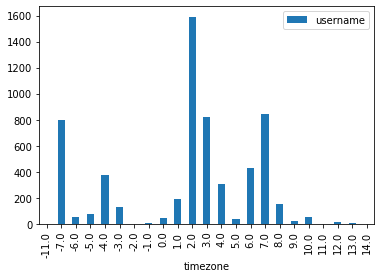

In [466]:
relevant_player_data[["username","timezone"]].groupby("timezone",as_index=False).count().sort_values(by="timezone").plot.bar(x="timezone",y="username")
# relevant_player_data.loc[relevant_player_data["timezone"]==2].groupby("iso_3").count().sort_values()

In [160]:
# player1 country, elo, elo-difference, country, join-date, start-time,moves-per-game,black-white, time, inc             with more info: games per day.
sql3 = "(SELECT game_id,count(move_num) num_moves FROM moves group by game_id) as move"
sql1 = f'''SELECT games.game_id, players.country_code,countries.timezone, games.player_white_username as username,games.white_elo as player_elo,(games.black_elo - games.white_elo) as elo_diff, players.join_date, games.start_time, games.inc,games.time_control, 'white' as white_or_black, move.num_moves, result_white as result 
FROM games 
LEFT OUTER JOIN players ON games.player_white_username = players.username
LEFT OUTER JOIN countries ON players.country_code = countries.alpha_2 
LEFT OUTER JOIN {sql3} ON  games.game_id = move.game_id
WHERE games.game_mode = 'chess' '''
sql2 = f'''SELECT games.game_id, players.country_code,countries.timezone, games.player_black_username as username,games.black_elo as player_elo,(games.white_elo - games.black_elo) as elo_diff, players.join_date, games.start_time,games.inc,games.time_control,'black' as white_or_black,move.num_moves, result_black as result FROM games 
LEFT OUTER JOIN players ON games.player_black_username = players.username
LEFT OUTER JOIN countries ON players.country_code = countries.alpha_2 
LEFT OUTER JOIN {sql3} ON  games.game_id = move.game_id
WHERE games.game_mode = 'chess' '''
sql12 = f"{sql1} UNION {sql2}"

# print(sql12)
con = table_interact.connect()
training_data = pd.read_sql(sql12,con)


In [161]:
con.close()
training_data.to_csv("training_data.csv")

In [316]:
training_data = pd.read_csv("training_data.csv")
px.imshow(training_data[["timezone","player_elo","join_date"]].corr())

<AxesSubplot:>

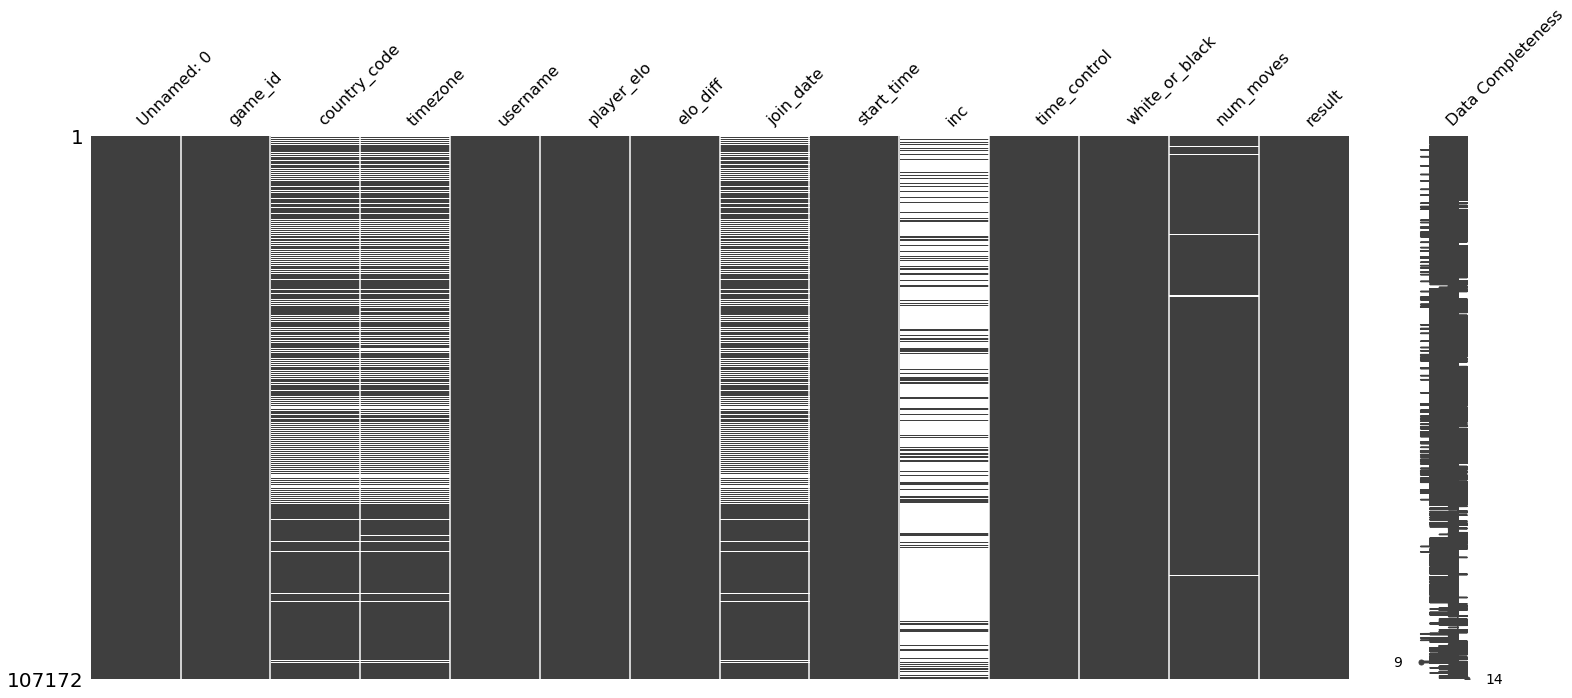

In [317]:
import missingno as msno 
msno.matrix(training_data,labels=True)

<AxesSubplot:>

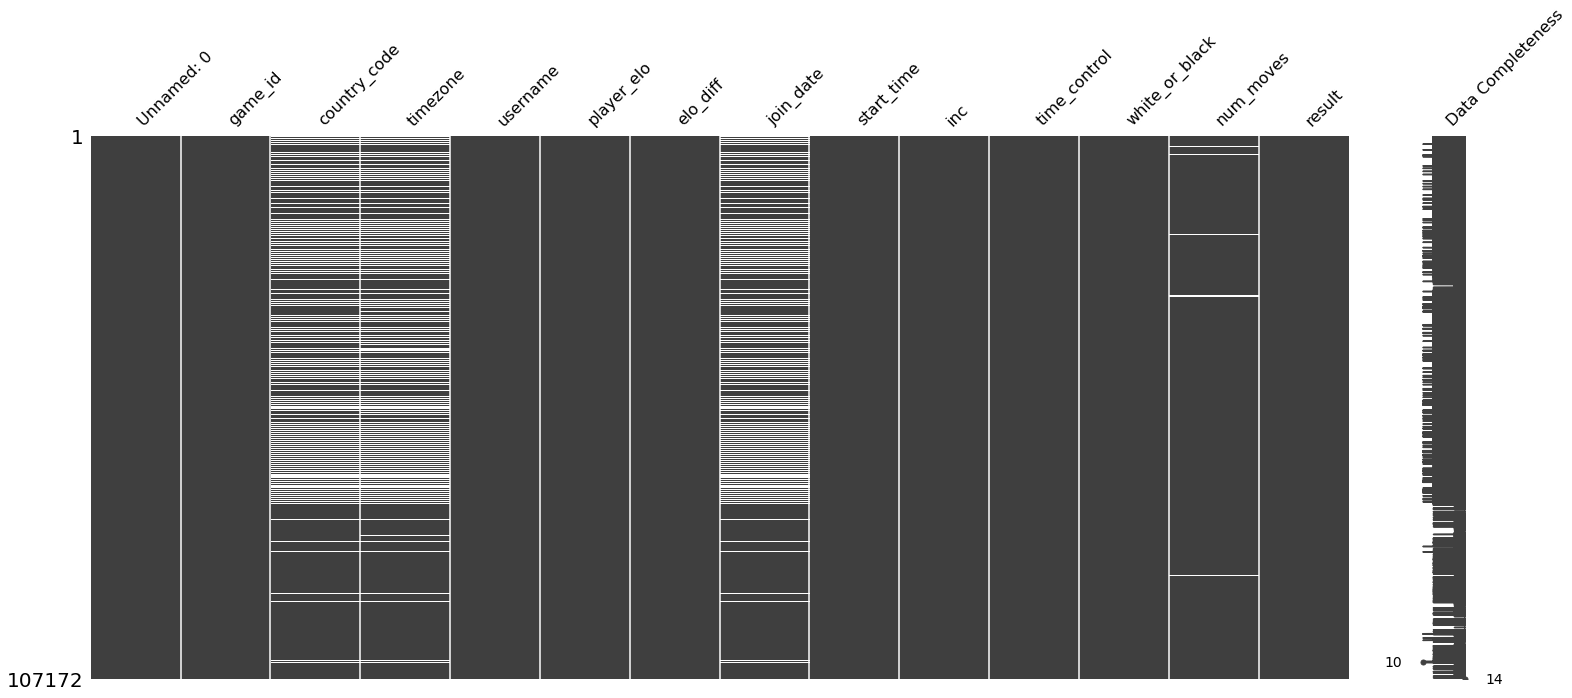

In [318]:
training_data["inc"] = training_data["inc"].fillna(0)
msno.matrix(training_data,labels=True)

In [319]:
training_data = training_data.dropna(subset=["country_code","timezone"])
training_data.drop(columns = "join_date",inplace = True)

<AxesSubplot:>

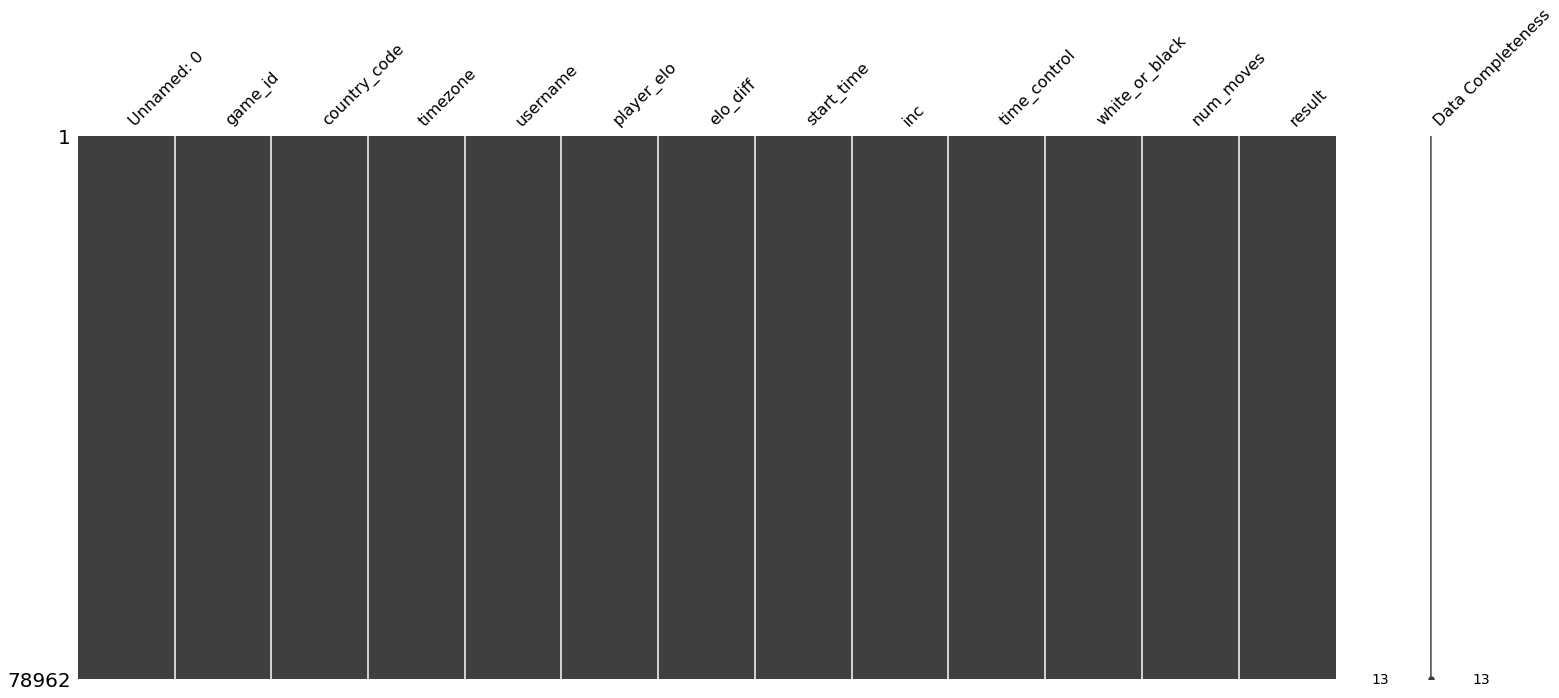

In [320]:
training_data["num_moves"]=training_data["num_moves"].fillna(35)
msno.matrix(training_data,labels=True)

0.0
23.0


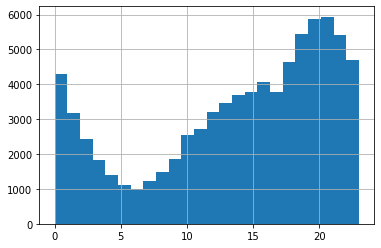

In [321]:
training_data["adjusted_time"] = training_data["start_time"].map(lambda adjusted: int(adjusted.split(":")[0]))
training_data["adjusted_time"] = training_data["adjusted_time"] + training_data["timezone"]
training_data["adjusted_time"].loc[training_data["adjusted_time"]>=24] =training_data["adjusted_time"].loc[training_data["adjusted_time"]>=24] -24
training_data["adjusted_time"].loc[training_data["adjusted_time"]<0] =training_data["adjusted_time"].loc[training_data["adjusted_time"]<0] + 24
training_data["adjusted_time"].hist(bins = 24)
print(min(training_data["adjusted_time"]))
print(max(training_data["adjusted_time"]))

#early = 6am to 9pm = 0
#midday = 10 to 1 =1 
#afternoon =  2 to 5 = 2
#eveining  = 6 to 9 = 3
#night = 10 to 1am = 4
#please sleep = 2am to 5am = 5
time_rep = {}
for i in range(1,5):
    time_rep[i-11] =2
    time_rep[i-7] =3
    time_rep[i-3] =4
    time_rep[i+1] =5
    time_rep[i+5] =0
    time_rep[i+9] =1
    time_rep[i+13] =2
    time_rep[i+17] =3
    time_rep[i+21] =4
    time_rep[i+25] =5
    time_rep[i+29] =0
    time_rep[i+33] =1
training_data["adjusted_time"] = training_data["adjusted_time"].replace(time_rep)

<AxesSubplot:>

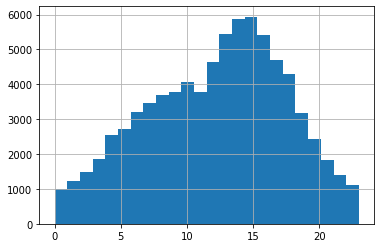

In [322]:
training_data["adjusted_time"] = training_data["adjusted_time"] -  6
training_data["adjusted_time"].loc[training_data["adjusted_time"]<0] =training_data["adjusted_time"].loc[training_data["adjusted_time"]<0] + 24
training_data["adjusted_time"].hist(bins=24)

In [323]:
px.box(training_data["elo_diff"], title="Boxplot of elo-differences")

In [324]:
#quantify game outcome
# capped at +-200 to avoid major sked
from statistics import mean,stdev
result_dict = {"checkmated" : -2.5,"win": 2.5,"resigned":-2.5,"timevsinsufficient":1,"agreed":0,"stalemate":0,"timeout":-1.5,"repetition":0,
"insufficient": -0.5, "abandoned":0,"50move":0}
training_data["performance"] = training_data["result"].replace(result_dict)
training_data["elo_diff"].loc[training_data["elo_diff"]>200]= 200
training_data["elo_diff"].loc[training_data["elo_diff"]<-200]= -200
training_data["elo_diff"] = 2*((training_data["elo_diff"] - min(training_data["elo_diff"]))/(max(training_data["elo_diff"])-min(training_data["elo_diff"]))) -1
print("max elo difference:{}".format(max(training_data["elo_diff"])))
print("min elo difference:{}".format(min(training_data["elo_diff"])))
print("mean average elo difference:{}".format(mean(training_data["elo_diff"])))
print("standard deviation elo difference:{}".format(stdev(training_data["elo_diff"])))


max elo difference:1.0
min elo difference:-1.0
mean average elo difference:0.0326502621514146
standard deviation elo difference:0.5514525109480403


<AxesSubplot:>

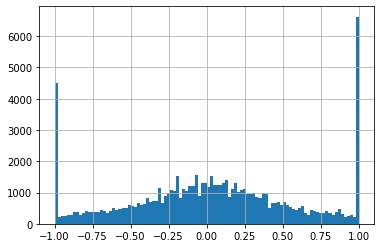

In [325]:
training_data["elo_diff"].hist(bins = 100)

In [326]:
training_data["metric"] = training_data["performance"] - 2.5*(training_data["elo_diff"])
training_data["total_game_time"] = training_data["num_moves"]*training_data["inc"] + training_data["time_control"]

<AxesSubplot:>

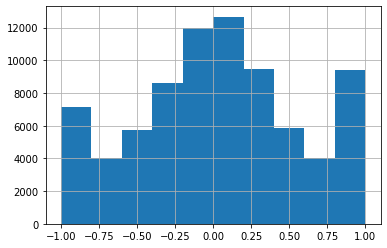

In [327]:
training_data["elo_diff"].hist()

In [328]:
#inputs player elo 
relevant_columns = ["player_elo","white_or_black_white","adjusted_time","metric","total_game_time","performance"]
fig = px.imshow(training_data[relevant_columns].corr())
fig.show()
X = training_data[["country_code","player_elo","white_or_black","adjusted_time","total_game_time"]]
y = training_data["metric"]

In [329]:
con = table_interact.connect()
sql = '''SELECT 
FROM players
(SELECT player_white_username,player_black_username,game_id,start_time,white_elo,black_elo,result_white,result_black FROM games WHERE game_mode = "Chess") as players_in_game'''
sql1 = '''SELECT result_white,count(game_id) FROM games WHERE game_mode = 'chess' group by result_white'''
sql2 = '''SELECT result_black,count(game_id) FROM games WHERE game_mode = 'chess' group by result_black'''
white_results = pd.read_sql(sql1,con)
black_results = pd.read_sql(sql2,con)
con.close()

In [330]:
white_results


,result_white,count
0,stalemate,254
1,50move,16
2,insufficient,1021
3,agreed,2044
4,timeout,5223
5,timevsinsufficient,635
6,resigned,14067
7,win,24995
8,repetition,2418
9,abandoned,155


In [365]:
px.pie(white_results,values='count', names='result_white', title='breakdown of results as white')

In [332]:
px.pie(black_results,values='count', names='result_black', title='breakdown of results as black')

In [333]:
# training_data[relevant_columns] = pd.get_dummies(training_data[relevant_columns],prefix_sep="_",drop_first=True)

In [366]:
import statsmodels.formula.api as smf
formula_string = ("+".join(relevant_columns)).replace("+metric","")
formula_string = formula_string.replace("+performance","")
# formula_string = formula_string.replace("+adjusted_time","")

print(formula_string)

model = smf.ols(formula=f'metric ~ {formula_string}', data=training_data[relevant_columns]).fit()
model.summary()

player_elo+white_or_black+adjusted_time+total_game_time


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2291.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:28:32   Log-Likelihood:            -1.9699e+05
No. Observations:               78962   AIC:                         3.940e+05
Df Residuals:                   78957   BIC:                         3.940e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -10.8323      0.117    -92.251      0.000     -11.062     -10.602
white_or_black[T.white]     0.2661      0.021     12.750      0.000       0.225       0.307
player_elo                  0.0039   4.11e-05     93.996      0.000       0.004       0.004
adjusted_time               0.0014      0.002      0.727      0.467      -0.002       0.005
total_game_time             0.0010   5.08e-05     19.658      0.000       0.001       0.001
==============================================================================
Omnibus:                    74852.205   Durbin-Watson:                   2.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4874.988
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       1.793   Cond. No.                     3.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [372]:

relevant_columns = ["player_elo","white_or_black","adjusted_time","metric","total_game_time"]
formula_string = ("+".join(relevant_columns)).replace("+metric","")
formula_string = formula_string.replace("+performance","")
formula_string = formula_string.replace("+adjusted_time","")
formula_string = formula_string.replace("white_or_black","C(white_or_black_white)")
# print(formula_string)
model = smf.ols(formula=f'adjusted_time ~ {formula_string}', data=pd.get_dummies(training_data[relevant_columns],drop_first=True)).fit()
print(f"adjusted_time VIF: {1/(1-model.rsquared)}")

formula_string = ("+".join(relevant_columns)).replace("+metric","")
formula_string = formula_string.replace("+performance","")
formula_string = formula_string.replace("+white_or_black","")
formula_string = formula_string.replace("white_or_black","C(white_or_black_white)")
# print(formula_string)
model = smf.ols(formula=f'white_or_black_white ~ {formula_string}', data=pd.get_dummies(training_data[relevant_columns],drop_first=True)).fit()
print(f"white_or_black VIF: {1/(1-model.rsquared)}")

formula_string = ("+".join(relevant_columns)).replace("+metric","")
formula_string = formula_string.replace("+performance","")
formula_string = formula_string.replace("player_elo+","")
formula_string = formula_string.replace("white_or_black","C(white_or_black_white)")
# print(formula_string)
model = smf.ols(formula=f'player_elo ~ {formula_string}', data=pd.get_dummies(training_data[relevant_columns],drop_first=True)).fit()
print(f"player_elo VIF: {1/(1-model.rsquared)}")

formula_string = ("+".join(relevant_columns)).replace("+metric","")
formula_string = formula_string.replace("+performance","")
formula_string = formula_string.replace("+total_game_time","")
formula_string = formula_string.replace("white_or_black","C(white_or_black_white)")
# print(formula_string)
model = smf.ols(formula=f'total_game_time ~ {formula_string}', data=pd.get_dummies(training_data[relevant_columns],drop_first=True)).fit()
print(f"total_game_time VIF: {1/(1-model.rsquared)}")

formula_string = ("+".join(relevant_columns)).replace("metric","")
formula_string = formula_string.replace("+performance","")
formula_string = formula_string.replace("white_or_black","C(white_or_black_white)")
# print(formula_string)
model = smf.ols(formula=f'metric ~ {formula_string}', data=pd.get_dummies(training_data[relevant_columns],drop_first=True)).fit()
print(f"performance metric VIF: {1/(1-model.rsquared)}")


adjusted_time VIF: 1.0015039219522295
white_or_black VIF: 1.0000102799555666
player_elo VIF: 1.1238482719156733
total_game_time VIF: 1.1230204208838583
performance metric VIF: 1.1160763956130328


In [363]:
from sklearn.model_selection import train_test_split
X = training_data[relevant_columns]
X_train,X_test = train_test_split(X,test_size=0.3)
X_test,X_val = train_test_split(X_test,test_size=0.5)
print(f"length of x_train = {len(X_train)}")
print(f"length of x_test = {len(X_test)}")
print(f"length of x_val = {len(X_val)}")

length of x_train = 55273
length of x_test = 11844
length of x_val = 11845
